<style>
    div.jp-MarkdownCell, div.jp-RenderedMarkdown {
        font-family: "Times New Roman", Times, serif;
    }
</style>


## Praktikum Data Mining II
#### Harvest Walukow - 164231104
##### Klasifikasi dengan CNN

In [1]:
# setup: versi dan impor
import sys, platform, numpy as np, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print({
    'python': sys.version.split()[0],
    'tensorflow': tf.__version__,
    'keras': keras.__version__,
    'cuda_available': tf.config.list_physical_devices('GPU') != []
})


{'python': '3.12.12', 'tensorflow': '2.19.0', 'keras': '3.10.0', 'cuda_available': True}


In [2]:
# load CIFAR-10
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
y_train = y_train.flatten()
y_test = y_test.flatten()
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

print('Train:', x_train.shape, y_train.shape)
print('Test :', x_test.shape, y_test.shape)
print('Kelas:', class_names)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step
Train: (50000, 32, 32, 3) (50000,)
Test : (10000, 32, 32, 3) (10000,)
Kelas: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [3]:
# preprocessing: normalisasi ke [0,1] dan split validasi dari train
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# buat split validasi 10% dari train
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.1, random_state=42, stratify=y_train
)

print('Train:', x_train.shape, y_train.shape)
print('Valid:', x_val.shape, y_val.shape)
print('Test :', x_test.shape, y_test.shape)


Train: (45000, 32, 32, 3) (45000,)
Valid: (5000, 32, 32, 3) (5000,)
Test : (10000, 32, 32, 3) (10000,)


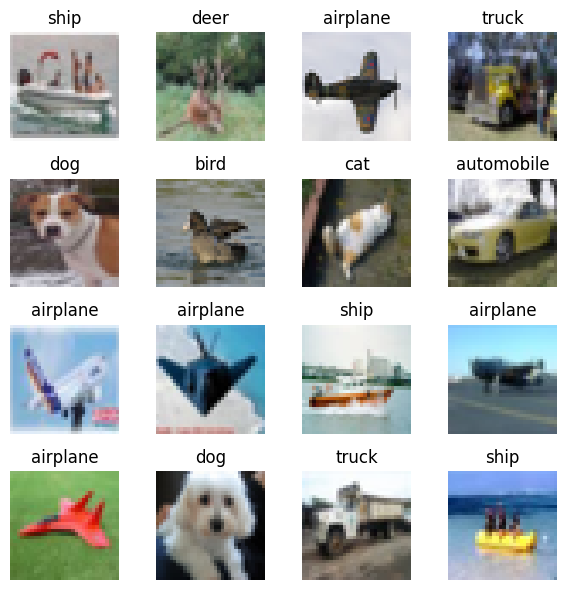

In [4]:
# visualisasi sampel
idx = np.random.choice(len(x_train), size=16, replace=False)
images = x_train[idx]
labels = y_train[idx]

plt.figure(figsize=(6,6))
for i, (img, lbl) in enumerate(zip(images, labels)):
    plt.subplot(4,4,i+1)
    plt.imshow(img)
    plt.title(class_names[lbl])
    plt.axis('off')
plt.tight_layout()
plt.show()


## Penjelasan Preprocessing
- Normalisasi piksel ke rentang [0,1] membantu stabilitas dan kecepatan konvergensi saat training.
- Split validasi diambil 10% dari data latih secara stratified agar distribusi kelas seimbang antara train/val.
- Visualisasi sampel berguna untuk sanity check kualitas data dan label.
- Augmentasi data ditambahkan untuk meningkatkan generalisasi (flip, rotate, crop).


In [5]:
# data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1)
], name='data_augmentation')

# membangun model CNN
inputs = keras.Input(shape=(32,32,3))
x = data_augmentation(inputs)

x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)

x = layers.Dropout(0.3)(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = keras.Model(inputs, outputs, name='cifar10_cnn')
model.summary()


Model: "cifar10_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 816,938 (3.12 MB)

 Trainable params: 815,530 (3.11 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [6]:
# compile dan training
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1)
]

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=25,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print({'test_loss': float(test_loss), 'test_acc': float(test_acc)})


Epoch 1/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.3679 - loss: 1.9796 - val_accuracy: 0.3518 - val_loss: 1.9754 - learning_rate: 0.0010
Epoch 2/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.5738 - loss: 1.1983 - val_accuracy: 0.6484 - val_loss: 1.0661 - learning_rate: 0.0010
Epoch 3/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.6515 - loss: 0.9859 - val_accuracy: 0.7070 - val_loss: 0.8401 - learning_rate: 0.0010
Epoch 4/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.6968 - loss: 0.8653 - val_accuracy: 0.7124 - val_loss: 0.8256 - learning_rate: 0.0010
Epoch 5/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.7292 - loss: 0.7786 - val_accuracy: 0.7474 - val_loss: 0.7214 - learning_rate: 0.0010
Epoch 6/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.7491 - loss: 0.7181 - val_accuracy: 0.7582 - val_loss: 0.6788 - learning_rate: 0.0010
Epoch 7/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.7667 - l

Confusion matrix shape: (10, 10)


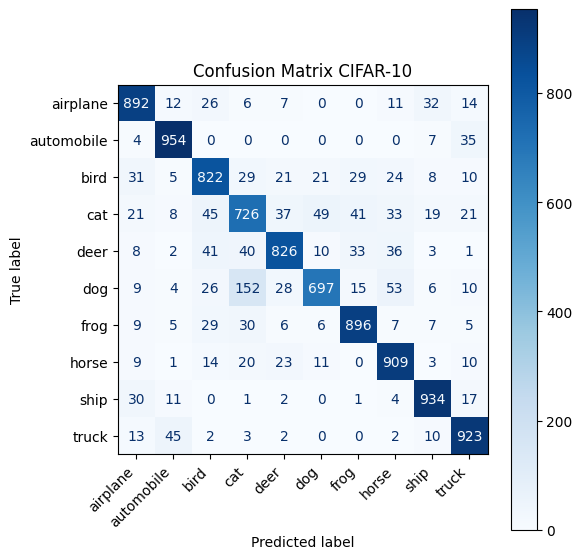

              precision    recall  f1-score   support

    airplane     0.8694    0.8920    0.8806      1000
  automobile     0.9112    0.9540    0.9321      1000
        bird     0.8179    0.8220    0.8200      1000
         cat     0.7210    0.7260    0.7235      1000
        deer     0.8676    0.8260    0.8463      1000
         dog     0.8778    0.6970    0.7770      1000
        frog     0.8828    0.8960    0.8893      1000
       horse     0.8424    0.9090    0.8745      1000
        ship     0.9077    0.9340    0.9207      1000
       truck     0.8824    0.9230    0.9022      1000

    accuracy                         0.8579     10000
   macro avg     0.8580    0.8579    0.8566     10000
weighted avg     0.8580    0.8579    0.8566     10000



In [9]:
# evaluasi: prediksi, confusion matrix, classification report
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# prediksi kelas pada data uji
y_prob = model.predict(x_test, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix shape:', cm.shape)
fig, ax = plt.subplots(figsize=(6,6))
ConfusionMatrixDisplay(cm, display_labels=class_names).plot(ax=ax, cmap='Blues', values_format='d')
ax.set_xticklabels(class_names, rotation=45, ha='right')
plt.title('Confusion Matrix CIFAR-10')
plt.tight_layout()
plt.show()

# classification report
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))


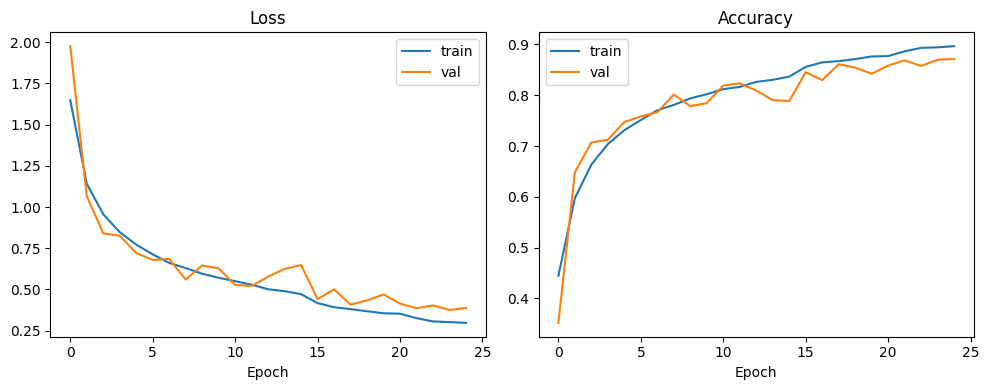

In [8]:
# plot kurva training (loss & accuracy)
history_dict = history.history
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_dict['loss'], label='train')
plt.plot(history_dict['val_loss'], label='val')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_dict['accuracy'], label='train')
plt.plot(history_dict['val_accuracy'], label='val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()


## Algoritma Klasifikasi yang Digunakan (CNN)
Kami menggunakan Convolutional Neural Network (CNN) karena efektif untuk data gambar:
- Ekstraksi fitur lokal via convolution (kernel kecil) mempertahankan informasi spasial.
- Pooling mengurangi dimensi dan membuat representasi lebih robust.
- Batch Normalization menstabilkan distribusi aktivasi, mempercepat konvergensi.
- Dropout mengurangi overfitting dengan menonaktifkan sebagian neuron saat training.
- Softmax pada output memodelkan probabilitas 10 kelas CIFAR-10.

Arsitektur yang dipakai: blok Conv2D + BN berulang, diikuti MaxPooling, lalu Dense untuk klasifikasi.


## Loss Function dan Metrik yang Digunakan
- Loss: `sparse_categorical_crossentropy` karena label berupa integer (0-9) dan output softmax 10 kelas. Loss ini memaksimalkan likelihood label benar dan umum untuk multi-class classification.
- Metrik: `accuracy` untuk mengukur proporsi prediksi benar. Pada CIFAR-10 yang seimbang, accuracy representatif dan mudah diinterpretasikan.
- Selain itu, ditampilkan `confusion matrix` dan `classification report` (precision, recall, F1 per kelas) untuk analisis kesalahan per kelas.

Alasan: Cross-entropy selaras dengan tujuan memprediksi kelas benar; accuracy menjadi metrik ringkas performa global; precision/recall/F1 memberi gambaran tradeoff dan kelas mana yang paling menantang.


## Analisis Hasil

Model mencapai akurasi 85,79%.

Hasil terbaik terlihat pada kelas kendaraan seperti automobile (precision 0,91; recall 0,95) dan ship (0,91; 0,93), serta kelas frog (0,88; 0,90). Ini berarti ketika model memprediksi kelas-kelas tersebut, jarang salah (precision tinggi) dan juga jarang melewatkan sampel yang benar (recall tinggi). Hasil ini konsisten dengan pola di CIFAR‑10, di mana bentuk/tekstur kendaraan dan “frog” seringkali lebih khas dibandingkan hewan lain.

Sebaliknya, kelas hewan tertentu masih ada beberapa kesalahan. Kelas cat memiliki precision 0,72 dan recall 0,73, sedangkan dog memiliki precision 0,88 tetapi recall rendah 0,70. Ini menunjukkan model cukup baik saat menyebut dog (prediksi dog relatif tepat), namun masih ada cukup banyak false negative. Kebingungan juga terjadi antara deer dan horse. Pola ini wajar karena resolusi 32×32 yang rendah dan kemiripan tekstur/bentuk antar hewan, serta latar belakang yang bervariasi.